<a href="https://colab.research.google.com/github/Jorge-89/Data-Science-CoderHouse/blob/main/datos_GFS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [133]:
%matplotlib inline

In [134]:
pip install netCDF4


# NCSS and CartoPy


Use Siphon to query the NetCDF Subset Service (NCSS) and plot on a map.

This example uses Siphon's NCSS class to provide temperature data
for contouring a basic map using CartoPy.



In [135]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from netCDF4 import num2date
import numpy as np

from siphon.catalog import TDSCatalog

First we construct a `TDSCatalog` instance pointing to our dataset of interest, in
this case TDS' "Best" virtual dataset for the GFS global 0.25 degree collection of
GRIB files. This will give us a good resolution for our map. This catalog contains a
single dataset.



In [136]:
best_gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/'
                      'Global_0p25deg/catalog.xml?dataset=grib/NCEP/GFS/Global_0p25deg/Best')
print(list(best_gfs.datasets))

['Best GFS Quarter Degree Forecast Time Series']


We pull out this dataset and get the NCSS access point



In [137]:
best_ds = best_gfs.datasets[0]
ncss = best_ds.subset()

We can then use the `ncss` object to create a new query object, which
facilitates asking for data from the server.



In [138]:
query = ncss.query()

We construct a query asking for data corresponding to a latitude and longitude box where 43
lat is the northern extent, 35 lat is the southern extent, -111 long is the western extent
and -100 is the eastern extent. We request the data for the current time.

We also ask for NetCDF version 4 data, for the variable 'temperature_surface'. This request
will return all surface temperatures for points in our bounding box for a single time,
nearest to that requested. Note the string representation of the query is a properly encoded
query string.



In [139]:
#query.lonlat_box(north=-29, south=-35, east=-61, west=-66).time(datetime.utcnow())

from datetime import datetime, timedelta

# Obtener la fecha y hora actual
now = datetime.utcnow()

# Calcular la fecha de ayer
yesterday = now - timedelta(days=2)

# Modificar la consulta para usar la fecha de ayer
query.lonlat_box(north=-29, south=-35, east=-61, west=-66).time(yesterday)

query.accept('netcdf4')
query.variables('Temperature_surface')

var=Temperature_surface&time=2024-05-26T11%3A59%3A26.463667&west=-66&east=-61&south=-35&north=-29&accept=netcdf4

In [140]:
time(datetime.utcnow())

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 12.4 µs


datetime.datetime(2024, 5, 28, 11, 59, 26, 483228)

We now request data from the server using this query. The `NCSS` class handles parsing
this NetCDF data (using the `netCDF4` module). If we print out the variable names, we see
our requested variable, as well as the coordinate variables (needed to properly reference
the data).



In [141]:
data = ncss.get_data(query)
print(list(data.variables))

['time1', 'latitude', 'reftime1', 'longitude', 'Temperature_surface', 'LatLon_721X1440-0p13S-180p00E-2']


We'll pull out the useful variables for temperature, latitude, and longitude, and time
(which is the time, in hours since the forecast run).



In [142]:
temp_var = data.variables['Temperature_surface']

# Time variables can be renamed in GRIB collections. Best to just pull it out of the
# coordinates attribute on temperature
time_name = temp_var.coordinates.split()[1]
time_var = data.variables[time_name]
lat_var = data.variables['latitude']
lon_var = data.variables['longitude']

Now we make our data suitable for plotting.



In [143]:
# Get the actual data values and remove any size 1 dimensions
temp_vals = temp_var[:].squeeze()
lat_vals = lat_var[:].squeeze()
lon_vals = lon_var[:].squeeze()

# Convert the number of hours since the reference time to an actual date
time_val = num2date(time_var[:].squeeze(), time_var.units)

# Convert temps to Fahrenheit from Kelvin
temp_vals = temp_vals -273

# Combine 1D latitude and longitudes into a 2D grid of locations
lon_2d, lat_2d = np.meshgrid(lon_vals, lat_vals)

Now we can plot these up using matplotlib and cartopy.



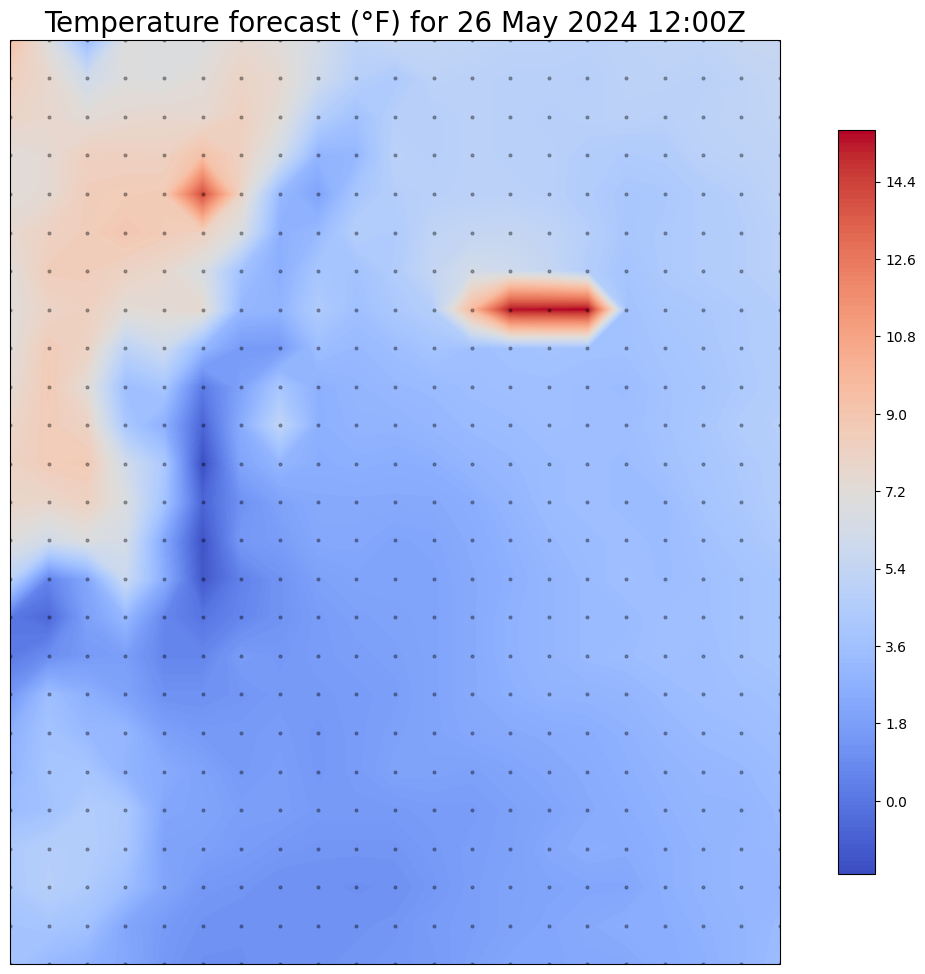

In [144]:
# Create a new figure
fig = plt.figure(figsize=(15, 12))

# Add the map and set the extent
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-61, -66, -35, -29])



# Add state boundaries to plot
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=2)

# Contour temperature at each lat/long
cf = ax.contourf(lon_2d, lat_2d, temp_vals, 200, transform=ccrs.PlateCarree(), zorder=0,
                 cmap='coolwarm')

# Plot a colorbar to show temperature and reduce the size of it
plt.colorbar(cf, ax=ax, fraction=0.032)

# Make a title with the time value
ax.set_title(u'Temperature forecast (\u00b0F) for {0:%d %B %Y %H:%MZ}'.format(time_val),
             fontsize=20)

# Plot markers for each lat/long to show grid points for 0.25 deg GFS
ax.plot(lon_2d.flatten(), lat_2d.flatten(), marker='o', color='black', markersize=2,
        alpha=0.3, transform=ccrs.Geodetic(), zorder=2, linestyle='none')

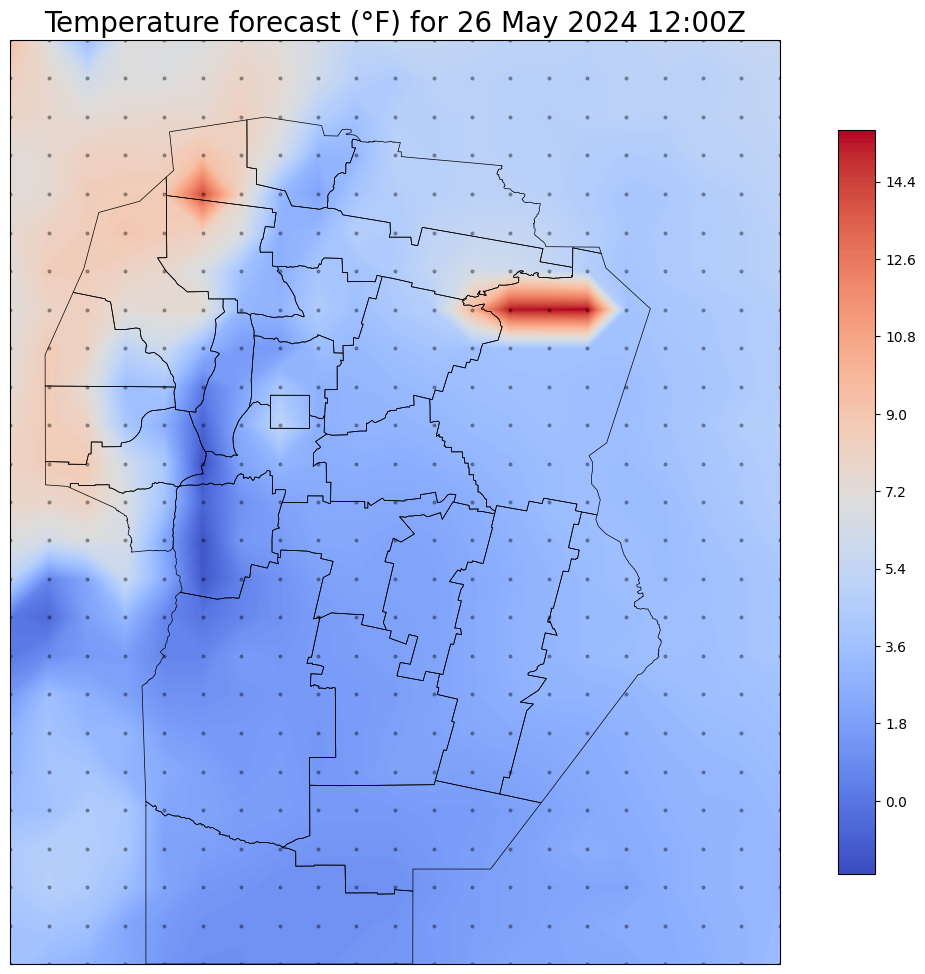

In [145]:
import cartopy.io.shapereader as shpreader

# Create a new figure
fig = plt.figure(figsize=(15, 12))

# Add the map and set the extent
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-61, -66, -35, -29])

# Add state boundaries to plot
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=2)

# Add topojson layer
topojson_path = '/content/departamentos-cordoba.topojson'  # Replace with the actual path to your topojson file
reader = shpreader.Reader(topojson_path)
ax.add_geometries(reader.geometries(), ccrs.PlateCarree(), edgecolor='black', facecolor='none', linewidth=0.5)

# Contour temperature at each lat/long
cf = ax.contourf(lon_2d, lat_2d, temp_vals, 200, transform=ccrs.PlateCarree(), zorder=0, cmap='coolwarm')

# Plot a colorbar to show temperature and reduce the size of it
plt.colorbar(cf, ax=ax, fraction=0.032)

# Make a title with the time value
ax.set_title(u'Temperature forecast (\u00b0F) for {0:%d %B %Y %H:%MZ}'.format(time_val), fontsize=20)

# Plot markers for each lat/long to show grid points for 0.25 deg GFS
ax.plot(lon_2d.flatten(), lat_2d.flatten(), marker='o', color='black', markersize=2, alpha=0.3,
        transform=ccrs.Geodetic(), zorder=2, linestyle='none')

<ipython-input-146-75c3f3f3c04c>:28: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  region_shape = cascaded_union([shape(geom) for geom in geometries])


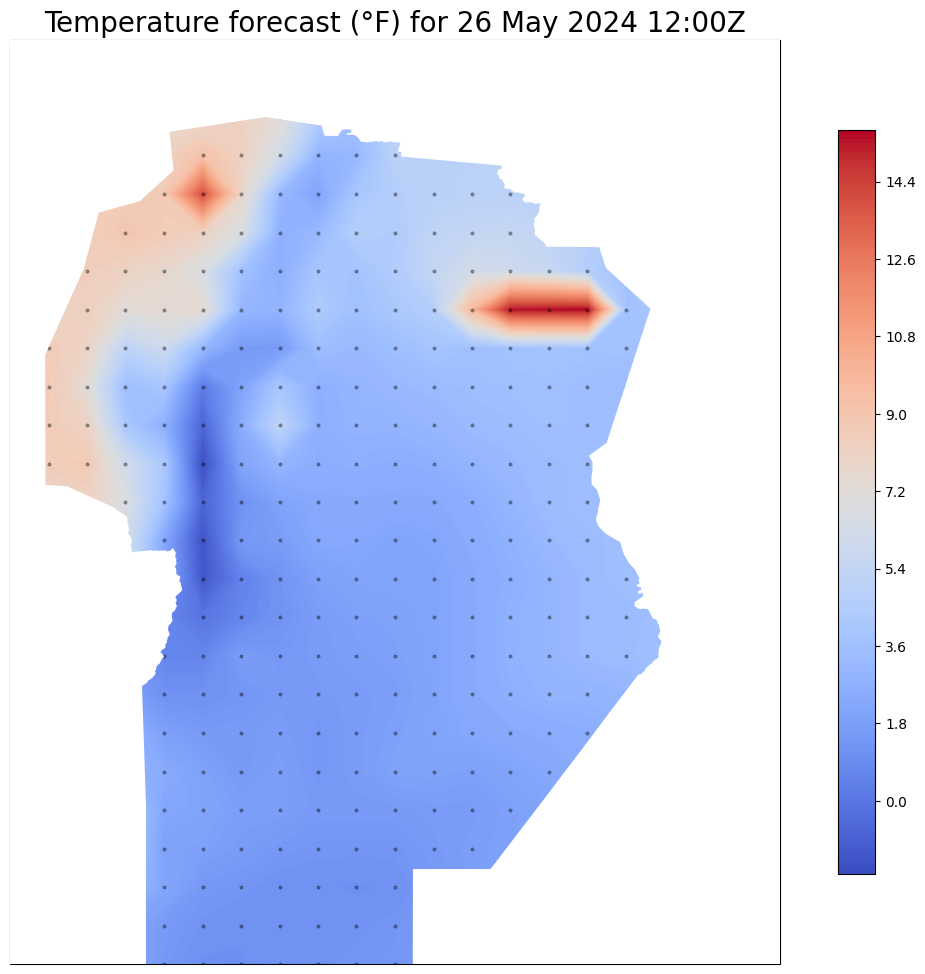

In [146]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import numpy as np
from shapely.geometry import shape, box
from shapely.ops import cascaded_union
from cartopy.mpl.patch import geos_to_path
from matplotlib.path import Path
from matplotlib.patches import PathPatch

# Create a new figure
fig = plt.figure(figsize=(15, 12))

# Add the map and set the extent
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-66, -61, -35, -29])  # Adjust the extent to match your area of interest

# Add state boundaries to plot
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=2)

# Add topojson layer
topojson_path = '/content/departamentos-cordoba.topojson'  # Replace with the actual path to your topojson file
reader = shpreader.Reader(topojson_path)

# Extract geometries and create a union of them to form a single shape
geometries = list(reader.geometries())
region_shape = cascaded_union([shape(geom) for geom in geometries])

# Define the bounding box for the area of interest
minx, miny, maxx, maxy = ax.get_extent(crs=ccrs.PlateCarree())

# Create a mask that covers the whole extent
bounding_box = box(minx, miny, maxx, maxy)

# Subtract the region shape from the bounding box to get the external mask
external_mask = bounding_box.difference(region_shape)

# Convert the shapely geometry to a matplotlib Path
paths = list(geos_to_path(external_mask))

# Create a mask from the Path
for path in paths:
    patch = PathPatch(path, transform=ccrs.PlateCarree(), facecolor='white', edgecolor='none', zorder=3)
    ax.add_patch(patch)

# Contour temperature at each lat/long
cf = ax.contourf(lon_2d, lat_2d, temp_vals, 200, transform=ccrs.PlateCarree(), zorder=0, cmap='coolwarm')

# Plot a colorbar to show temperature and reduce the size of it
plt.colorbar(cf, ax=ax, fraction=0.032)

# Make a title with the time value
ax.set_title(u'Temperature forecast (\u00b0F) for {0:%d %B %Y %H:%MZ}'.format(time_val), fontsize=20)

# Plot markers for each lat/long to show grid points for 0.25 deg GFS
ax.plot(lon_2d.flatten(), lat_2d.flatten(), marker='o', color='black', markersize=2, alpha=0.3,
        transform=ccrs.Geodetic(), zorder=2, linestyle='none')

plt.show()